The project below was constructed in 6 days as a test. 

In [38]:
from __future__ import division, print_function 
import os
import numpy as np
import collections as cls
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import re
import glob
import itertools
import math
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import RandomizedLasso
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from matplotlib import pylab
from scipy import stats
from pylab import *
random_state = 10

# 1. Data Loading

The dataset of European capitals was used for this analysis and prediction task.

In [3]:
#get all city names
all_cities_paths =  glob.glob(os.path.join(os.getcwd(), 'data','*'))
cities = []
for city in all_cities_paths:
    cities.append(city.split("/")[-1])
print(cities)
                    

['amsterdam', 'berlin', 'copenhagen', 'dublin', 'edinburgh', 'helsinki', 'lisbon', 'london', 'madrid', 'moscow', 'rome', 'tallin', 'vienna', 'paris', 'reykjavik']


In [4]:
#finds the not common elements of the two lists
#input: list1,list2 --> the lists to be compared
#output: the not common elements
def find_not_common_columns(list1,list2):
    not_common_cols = []
    both_lists = list1 + list2
    for col in set(both_lists):
        if col not in set(list1) or col not in set(list2):
            not_common_cols.append(col)
    return not_common_cols



Some columns' names had to be stripped as well as the majority of the timestamps. Moreover, some csv files containing data for the same city had some different columns from one another. The columns not contained to all of the csvs were reported. 

In [5]:
#loading each city's dataset to a dictionary and stripping their column titles from unwanted characters
#moreover checking which columns are not common for all csv files of a particular city in order to be discarded later
#in addition their last_modified column values are stripped
datasets = dict()
for city in cities:
    city_data = pd.DataFrame() #initializing city's dataframe
    data_path = glob.glob(os.path.join(os.getcwd(), 'data',city,city,'*.csv'))
    print('\n\n\n{}\n'.format(city))
    first = True
    file_columns = [] #containing the columns that the first file of the particular city contains
    for f in data_path:
        file_data =pd.read_csv(f,delimiter=",",lineterminator="\n") 
        old_columns = list(file_data.columns.values)
        new_columns = [] #containing the columns after the stripping
        for col in old_columns:
            new_columns.append(col.strip())
        if first:
            file_columns = new_columns
            first = False
        else:
            if file_columns == new_columns:
                print('no difference in the columns')
            else:
                print('DIFFERENCE IN THE COLUMNS REPORTED')
                print('NOT COMMON COLUMNS: {}'.format(find_not_common_columns(file_columns,new_columns)))      
        file_data.columns = new_columns
        file_data['last_modified'] = file_data['last_modified'].apply(lambda x: x.strip()) #stripping all the values of 'last_modified' column
        city_data = pd.concat([city_data,file_data],ignore_index=True)
    print('\n{}\'s dataset length: {}'.format(city,len(city_data.index)))
    datasets[city] = city_data




amsterdam

no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
DIFFERENCE IN THE COLUMNS REPORTED
NOT COMMON COLUMNS: ['survey_id', 'bathrooms', 'city', 'country', 'location', 'name']
DIFFERENCE IN THE COLUMNS REPORTED
NOT COMMON COLUMNS: ['survey_id', 'bathrooms', 'city', 'country', 'location', 'name']

amsterdam's dataset length: 184551



berlin

no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
D

# 2. Exploratory Data Analysis and Pre-processing

The columns containing only missing values were dropped immediately. In contrast, the columns containing some missing values were reported along with the percentage of the rows containing a null value and they are dealt with later, depending on their importance and the magnitude of the null percentage.

In [6]:
#find out which of the columns of each city's dataset have missing values 
#and delete the columns that have only missing values
city_columns = dict() #it is going to conatin the feature list of each city
for city in datasets.keys():
    city_data = datasets[city]
    all_data = len(city_data.index)
    columns = city_data.columns.values
    city_columns[city] = list(columns)
    some_mis = dict()
    only_mis = []
    for col in columns:
        bools = city_data[col].to_frame().isnull()
        num = len(bools[bools[col] == True].index) #number of mssing values in the particular column
        if num > 0: #if there is at least one missing value
            if num < len(city_data[col].index): #if not all values are missing
                some_mis[col] = num
            else:
                only_mis.append(col) #if all values of the column are missing
    print_str = '\n{} '.format(city)
    if len(some_mis.keys()) > 0:
        first = True
        for col in some_mis.keys():
            if first:
                first = False
                print_str += '\ncols with some missing values--> {}({}%)'.format(col,100*float(some_mis[col]/all_data))
            else:
                print_str += ',{}({}%)'.format(col,100*float(some_mis[col]/all_data))
    if len(only_mis) > 0:
        print_str += '\ncols with only missing values--> {}'.format(only_mis[0])
        for i in range(1,len(only_mis)):
            print_str += ',{}'.format(only_mis[i])
        city_data.drop(only_mis, axis=1, inplace=True) #deleting columns with only missing data
        datasets[city] = city_data
    print(print_str)
        
    


edinburgh 
cols with some missing values--> overall_satisfaction(13.393982944%),city(69.7384655016%),name(69.7411771086%),price(0.00271160703391%),bedrooms(0.139647762246%),accommodates(1.75712135797%),minstay(72.1260354949%),location(69.7384655016%),survey_id(69.7384655016%),room_type(0.00677901758477%)
cols with only missing values--> bathrooms,borough,country

reykjavik 
cols with some missing values--> city(78.223078474%),price(0.0201617419745%),bedrooms(9.57010685723%),overall_satisfaction(16.4363000963%),minstay(57.7745917247%),location(78.223078474%),survey_id(78.223078474%),room_type(0.0201617419745%)
cols with only missing values--> bathrooms,borough,country

helsinki 
cols with some missing values--> city(64.1407968712%),survey_id(64.1407968712%),name(64.3241261305%),bedrooms(0.0427768271816%),overall_satisfaction(12.1425079443%),minstay(88.1935956979%),location(64.1407968712%),property_type(64.1407968712%)
cols with only missing values--> bathrooms,borough,country

paris 
c

When replacing all null values based on our criteria was not achieved, the entries containing them were discarded. The numbers of the null values being replaced as well as the ones whose entire row was finally deleted are reported.

In [7]:
#which percentage of the rooms of each city has above 2 reviews
for city,data in datasets.iteritems():
    print('{}% of {}\'s rooms have above 2 reviews'.format
          (100 * float(len(data[data['reviews'] > 2].index)/len(data.index)),city))

66.2499830525% of edinburgh's rooms have above 2 reviews
69.5445686507% of reykjavik's rooms have above 2 reviews
60.4803226595% of helsinki's rooms have above 2 reviews
53.4631630683% of paris's rooms have above 2 reviews
56.684796912% of madrid's rooms have above 2 reviews
28.4624380464% of moscow's rooms have above 2 reviews
65.3361979788% of dublin's rooms have above 2 reviews
60.3791030975% of tallin's rooms have above 2 reviews
54.7269662742% of berlin's rooms have above 2 reviews
55.0347803573% of rome's rooms have above 2 reviews
48.6587340568% of london's rooms have above 2 reviews
67.3958816898% of lisbon's rooms have above 2 reviews
66.9045412921% of amsterdam's rooms have above 2 reviews
59.0389632032% of copenhagen's rooms have above 2 reviews
58.1383761211% of vienna's rooms have above 2 reviews


Given the fact that a big percentage of the overall_satisfaction column of all the cities was formed by two or less reviews, then it is apparent that it might be not worth to save this column.

In [8]:
#dealing with the columns which contain both missing and normal entries
columns_to_delete = ['city','location','survey_id','name','minstay','property_type','overall_satisfaction']
#city is not needed
#location is not needed
#survey_id is not needed
#name is not needed
#minstay have too many null values
#overall satisfaction cannot be used both because of the many null entries and because the reviews 
#are usually not enough to produce reliable assumptions
#property_type has too many values

delete_null_entries = ['price']
#these columns' values are too significant and they might change from time to time even for the same room
#as a result it seems wiser to delete the entries where these columns are null rather than replace them
#accommodates will be dealt with later

replace_nulls_median = ['bedrooms']
#given the fact that generally the same room appears multiple times inside each city's dataset these columns are going 
#to be replaced by the median of the column values inside the same room through time

replace_nulls_value = ['room_type','host_id']
#if the same room_id exists in the dataset with a non-null value for these fields then the null value is replaced 
#by that. If not the entries containing null values are removed

for city in datasets.keys():
    print('\n{}'.format(city))
    city_data = datasets[city]
    for col in columns_to_delete:
        if col in city_data.columns:
            city_data.drop([col], axis=1, inplace=True) #columns_to_delete are deleted
    old_num = len(city_data.index)
    
    for col in delete_null_entries:
        if col in city_data.columns:
            city_data.dropna(axis=0,subset = [col],inplace=True) #the null entries of delete_null_entries are deleted
        print('\n{}:\t{} values were deleted'.format(
                col,len(city_data[city_data[col].isnull()].index)))
            
    for col in replace_nulls_median:
        if col in city_data.columns:
            null_entries = city_data[['room_id']][city_data[col].isnull()]
            count = 0
            for index,row in null_entries.iterrows():
                same_room_entries = city_data[[col]][city_data['room_id'] == row['room_id']] 
                #get the rest of the entries of the particular room where the nul appeared
                if len(same_room_entries.index) > 0:
                    city_data.set_value(index,col,same_room_entries[col].median())
                    count += 1
                    #replacing the null value with the median of the values for the same room_id
            print('\n{}:\t{} values were replaced\t{} were not replaced and were deleted'.format(
                col,count,len(city_data[city_data[col].isnull()].index)))
            
            city_data.dropna(axis=0,subset = [col],inplace=True) #the null entries that were not replaced are deleted
    
    for col in replace_nulls_value:
        if col in city_data.columns:
            null_entries = city_data[['room_id']][city_data[col].isnull()]
            count = 0
            for index,row in null_entries.iterrows():
                same_room_entries = city_data[col][city_data['room_id'] == row['room_id']] 
                #get the rest of the entries of the particular room where the null appeared
                if len(same_room_entries.index) > 0:
                    city_data.set_value(index,col,same_room_entries.values[0])
                    count += 1
                    #replacing the null value with the value existing in the 
                    #same column of the first entry with the same room_id that appears
            print('\n{}:\t{} values were replaced\t{} were not replaced and were deleted'.format(
                col,count,len(city_data[city_data[col].isnull()].index)))
            
            city_data.dropna(axis=0,subset = [col],inplace=True) #the null entries that were not replaced are deleted    
            
            
    new_num = len(city_data.index)
    print('\n{}% of the {}\'s dataset was deleted'.format(100 * float((old_num-new_num)/len(city_data.index)), city))
    datasets[city] = city_data




edinburgh

price:	0 values were deleted

bedrooms:	101 values were replaced	17 were not replaced and were deleted

room_type:	3 values were replaced	1 were not replaced and were deleted

host_id:	0 values were replaced	0 were not replaced and were deleted

0.0271234251461% of the edinburgh's dataset was deleted

reykjavik

price:	0 values were deleted

bedrooms:	4263 values were replaced	23 were not replaced and were deleted

room_type:	0 values were replaced	0 were not replaced and were deleted

host_id:	0 values were replaced	0 were not replaced and were deleted

0.0717376196561% of the reykjavik's dataset was deleted

helsinki

price:	0 values were deleted

bedrooms:	7 values were replaced	3 were not replaced and were deleted

room_type:	0 values were replaced	0 were not replaced and were deleted

host_id:	0 values were replaced	0 were not replaced and were deleted

0.018336287513% of the helsinki's dataset was deleted

paris

price:	0 values were deleted

bedrooms:	2800 values wer

In [9]:
#find out which columns are existent to all of the cities and which are not
all_columns = set() # the union of columns appearing in all of the cities
all_common_columns = set() # the intersection of columns appearing in all of the cities
first = True
for city,columns in city_columns.iteritems():
    columns_set = set(columns) #since all the columns of the same city have a unique name
    for col in columns:
        all_columns.add(col)
    if first == False:
        mortals = [] #containing the columns that are going to be removed from the intersection
        for col in all_common_columns:
            if col not in columns_set:
                mortals.append(col)
        for mor in mortals: 
            all_common_columns.remove(mor)
    else:
        for col in columns:
            all_common_columns.add(col) #initializing the intersection
        first = False

all_common_list = list(all_common_columns) #set to list
if len(all_common_list) > 0:
    print_str = 'Features appearing to every city of the dataset:\n{}'.format(all_common_list[0])
    for i in range(1,len(all_common_list)): #the rest
        print_str += ',{}'.format(all_common_list[i])
    print(print_str)
else:
    print("There are no common features between the different cities")


print_str = "\nFeatures appearing only to some cities of the dataset:\n"
first = True
for col in all_columns:
    if(col not in all_common_columns):
        if first == True:
            print_str += col
            first = False
        else:
            print_str += "," + col

print(print_str)


    

Features appearing to every city of the dataset:
overall_satisfaction,neighborhood,longitude,price,bedrooms,accommodates,minstay,reviews,last_modified,room_id,latitude,host_id,borough,room_type

Features appearing only to some cities of the dataset:
city,survey_id,bathrooms,country,property_type,location,name


The 'accommodates' column is dealt with separately here. Both null and values below 1 are considered false and the rows containing them are discarded. 

In [10]:
#checking if some bad values exist in accommodates column for every city
bad_accommodates_value_found = False
error_cities = [] #containing the cities containing bad values in that column
for city,data in datasets.iteritems():
    print('\n{}:\n'.format(city))
    error_found = False
    bools = data['accommodates'].to_frame().isnull()
    numeric_error_entries = len(data[data['accommodates'] < 1].index) #number of entries with values less than 1
    missing_entries = len(bools[bools['accommodates'] == True].index) #number of entries with missing values
    if numeric_error_entries > 0:
        error_found = True
        print('Numeric error for {} entries ({}% of the city\'s dataset)'.format(numeric_error_entries,
                                                                                100*float(numeric_error_entries/
                                                                                         len(data.index))))
    if missing_entries > 0:
        error_found = True
        print('Missing value for {} entries ({}% of the city\'s dataset)'.format(missing_entries,
                                                                                100*float(missing_entries/
                                                                                         len(data.index))))
    if error_found:
        error_cities.append(city)
        bad_accommodates_value_found = True    

    
#deleting the bad value entries:
print('\n\n')
for city in error_cities:
    city_data = datasets[city]
    old_num = len(city_data.index)
    city_data = city_data[city_data['accommodates'] >= 1]
    city_data = city_data.dropna(axis=0,subset = ['accommodates'])
    new_num = len(city_data.index)
    datasets[city] = city_data
    print('{} entries were deleted from {}'.format(old_num - new_num,city))




edinburgh:

Missing value for 1294 entries (1.75488560695% of the city's dataset)

reykjavik:


helsinki:


paris:

Numeric error for 41 entries (0.00584604372556% of the city's dataset)
Missing value for 7718 entries (1.10048208473% of the city's dataset)

madrid:


moscow:

Missing value for 1365 entries (3.80265210608% of the city's dataset)

dublin:

Missing value for 388 entries (0.617568879622% of the city's dataset)

tallin:


berlin:

Missing value for 8919 entries (3.57234407293% of the city's dataset)

rome:

Missing value for 6121 entries (2.11395535172% of the city's dataset)

london:

Missing value for 12273 entries (2.36099595439% of the city's dataset)

lisbon:

Missing value for 2810 entries (2.33032574803% of the city's dataset)

amsterdam:

Missing value for 1319 entries (0.714870277331% of the city's dataset)

copenhagen:

Missing value for 1250 entries (0.803532973779% of the city's dataset)

vienna:

Missing value for 1056 entries (2.5059326056% of the city's data

A new column 'price_per_accommodated' is created and based on this column outlier detection is performed using a version of Tukey's test. The outliers are discarded.

In [11]:
#create new column: price per number of people that can be accommodated
for city in datasets.keys():
    city_data = datasets[city]
    city_data['price_per_accommodated'] = city_data['price'] / city_data['accommodates']
    datasets[city] = city_data

In [12]:
#input: p--> price, quartiles --> quartiles of price_per|_accommodated column,
#k --> tukey test's hyperparameter
#output: whether p is a low outlier, a high outlier or a normal instance
def tukey_test(p,quartiles,k):
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - k * iqr
    if(lower_bound < 1):
        lower_bound = 1 #we will not use the lower bound of tukey test but a fixed positive lower bound
        
    upper_bound  = quartiles[2] + k * iqr
    low_outliers = 0
    high_outliers = 0
    if p < lower_bound:
        return "low_outlier"
    elif p > upper_bound:
        return "high_outlier"
    return "no" 

In [13]:
#given the fact that some prices might be per month outlier detection method tukey test will be used
#so that these entries will be captures as outliers along with the rest of the outliers the dataset might have
#price_per_accommodated will be used instead of price column

k = 1.5 #tukey test's hyperparameter
all_low_outliers = 0
all_high_outliers = 0
all_data = 0
print('OUTLIER DETECTION AND DELETION')

for city in datasets.keys():
    mortal_indexes = []
    city_data = datasets[city]
    quartiles = []
    quartiles.append(city_data['price_per_accommodated'].to_frame().quantile(q=0.25,axis=0)[0])
    quartiles.append(city_data['price_per_accommodated'].to_frame().mean(axis=0)[0])
    quartiles.append(city_data['price_per_accommodated'].to_frame().quantile(q=0.75,axis=0)[0])
    city_low_outliers = 0
    city_high_outliers = 0
    city_data.reset_index(inplace=True)
    for index,row in city_data.iterrows():
        res = tukey_test(row['price_per_accommodated'],quartiles,k)
        if res == 'low_outlier':
            city_low_outliers += 1
            mortal_indexes.append(index)
        elif res == 'high_outlier':
            city_high_outliers += 1
            mortal_indexes.append(index)
    all_data += len(city_data.index)
    all_low_outliers += city_low_outliers
    all_high_outliers += city_high_outliers
    city_data = city_data.drop(city_data.index[mortal_indexes]) #deleting the outliers by their index
    
    datasets[city] = city_data
    print('{0}\t(LOW)\t{1}\t(HIGH)\t{2}\t(TOTAL)\t{3}\t{4}% of city\'s dataset'.
          format(city,city_low_outliers,city_high_outliers,city_low_outliers + city_high_outliers
                 ,100 * float((city_low_outliers + city_high_outliers)/len(city_data.index))))

print('\n\n\nALTOGETHER\t(LOW)\t{0}\t(HIGH)\t{1}\t(TOTAL)\t{2}\t{3}% of all cities\' datasets'.
          format(all_low_outliers,all_high_outliers,all_low_outliers + all_high_outliers
                 ,100 * float((all_low_outliers + all_high_outliers)/all_data)))
            
            
    
    

OUTLIER DETECTION AND DELETION
edinburgh	(LOW)	1	(HIGH)	3014	(TOTAL)	3015	4.34262833439% of city's dataset
reykjavik	(LOW)	0	(HIGH)	1737	(TOTAL)	1737	4.05178446466% of city's dataset
helsinki	(LOW)	0	(HIGH)	899	(TOTAL)	899	5.81425430087% of city's dataset
paris	(LOW)	5	(HIGH)	34461	(TOTAL)	34466	5.2292202748% of city's dataset
madrid	(LOW)	1	(HIGH)	1036	(TOTAL)	1037	4.76650119507% of city's dataset
moscow	(LOW)	340	(HIGH)	2462	(TOTAL)	2802	8.83103785181% of city's dataset
dublin	(LOW)	0	(HIGH)	3450	(TOTAL)	3450	5.84854803438% of city's dataset
tallin	(LOW)	15	(HIGH)	461	(TOTAL)	476	4.60392687881% of city's dataset
berlin	(LOW)	3	(HIGH)	10080	(TOTAL)	10083	4.37125540825% of city's dataset
rome	(LOW)	0	(HIGH)	13691	(TOTAL)	13691	5.07562838289% of city's dataset
london	(LOW)	3	(HIGH)	23936	(TOTAL)	23939	4.95005283172% of city's dataset
lisbon	(LOW)	23	(HIGH)	6969	(TOTAL)	6992	6.31149464714% of city's dataset
amsterdam	(LOW)	0	(HIGH)	5725	(TOTAL)	5725	3.22598822303% of city's dataset
copen

In [14]:
#showing the number of rooms per room_type and per city
for city,data in datasets.iteritems():
    print(city)
    gb = data.groupby(['room_type'])
    print(gb['room_type'].count().sort_values(ascending=False))


edinburgh
room_type
Entire home/apt    38750
Private room       30196
Shared room          482
Name: room_type, dtype: int64
reykjavik
room_type
Entire home/apt    31979
Private room        9850
Shared room         1041
Name: room_type, dtype: int64
helsinki
room_type
Entire home/apt    12455
Private room        2668
Shared room          339
Name: room_type, dtype: int64
paris
room_type
Entire home/apt    573536
Private room        80105
Shared room          5463
Name: room_type, dtype: int64
madrid
room_type
Entire home/apt    13447
Private room        8008
Shared room          301
Name: room_type, dtype: int64
moscow
room_type
Entire home/apt    21787
Private room        7934
Shared room         2008
Name: room_type, dtype: int64
dublin
room_type
Private room       29211
Entire home/apt    28249
Shared room         1529
Name: room_type, dtype: int64
tallin
room_type
Entire home/apt    8672
Private room       1509
Shared room         158
Name: room_type, dtype: int64
berlin
room_type


Some statistics regarding the average price per city and per room type are shown below. The mean is reported along with the standard deviation assumming naively that the prices and price_per_accommodated values are normally distributed.


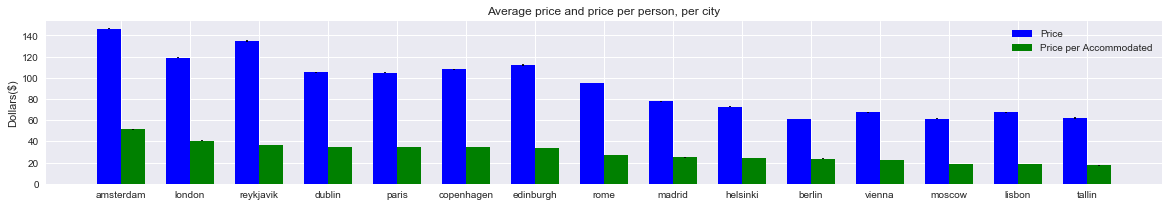

In [15]:
#creating bar chart showing the average prices and average prices per accommodated for all room types, per city
plt.clf()
N = len(datasets.keys())
price_means = []
price_stds = []
price_per_accommodated_means = []
price_per_accommodated_stds = []
cities = []

for city in datasets.keys():
    city_data = datasets[city]
    price_means.append(city_data['price'].mean())
    price_stds.append(2 * float(city_data['price'].std()/np.sqrt(len(city_data))))
    price_per_accommodated_means.append(city_data['price_per_accommodated'].mean())
    price_per_accommodated_stds.append(2 * float(city_data['price_per_accommodated'].std()/np.sqrt(len(city_data))))
    cities.append(city)


sort_indices = np.argsort(np.asarray(price_per_accommodated_means)) #sort cities on price per accommodated
price_means = list(np.asarray(price_means)[sort_indices[::-1]])
price_stds = list(np.asarray(price_stds)[sort_indices[::-1]])
price_per_accommodated_means = list(np.asarray(price_per_accommodated_means)[sort_indices[::-1]])
price_per_accommodated_stds = list(np.asarray(price_per_accommodated_stds)[sort_indices[::-1]])
cities = list(np.asarray(cities)[sort_indices[::-1]])


pos = np.arange(N)
width = 0.35

fig, ax = plt.subplots(figsize=(20,3))

prices_bar = ax.bar(pos, tuple(price_means), width, color='b', yerr=tuple(price_stds))
prices_pa_bar = ax.bar(pos+width, tuple(price_per_accommodated_means), width, 
                       color='g', yerr=tuple(price_per_accommodated_stds))

ax.legend((prices_bar[0], prices_pa_bar[0]), ('Price', 'Price per Accommodated'))

ax.set_ylabel('Dollars($)')
ax.set_title('Average price and price per person, per city')
ax.set_xticks(pos + width / 2)
ax.set_xticklabels(tuple(cities))

plt.show()

Supposing that we want to make a significant assumption that Amsterdam has more expensive flats than London. In order to do so we have to perform a significance test. We suppose that according to the null hypothesis London's and Amsterdam's mean price_per_person are equal. We want to reject that hypothesis.

In [41]:
#significance testing
city1 = 'amsterdam'
city2 = 'london'
ams_ppp = datasets[city1]['price_per_accommodated'].values
lon_ppp = datasets[city2]['price_per_accommodated'].values

_,pvalue = stats.ttest_ind(ams_ppp,lon_ppp)
print('The pvalue of the two-sided test between {} and {} is: {}'.format(city1,city2,pvalue))



The pvalue of the two-sided test between amsterdam and london is: 0.0


Since pvalue < 0.05 the null hypothesis is rejected. Thus, our assumption that Amsterdam has more expensive rooms per person accommodated is statistically significant.

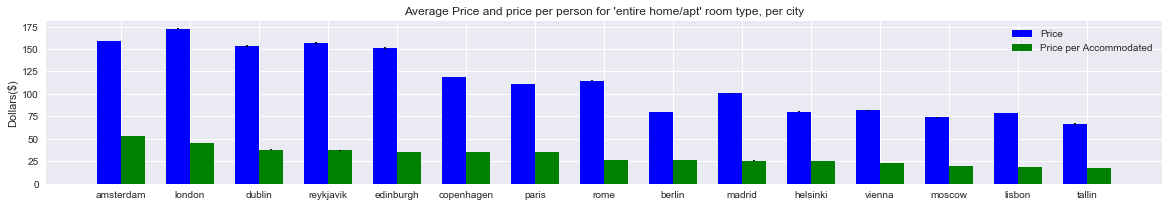

In [16]:
#creating bar chart showing the average prices and average prices per accommodated for all room types, per city
plt.clf()
N = len(datasets.keys())
price_means = []
price_stds = []
price_per_accommodated_means = []
price_per_accommodated_stds = []
cities = []

for city in datasets.keys():
    city_data = datasets[city]
    city_data = city_data[city_data['room_type'] == 'Entire home/apt']
    price_means.append(city_data['price'].mean())
    price_stds.append(2 * float(city_data['price'].std()/np.sqrt(len(city_data))))
    price_per_accommodated_means.append(city_data['price_per_accommodated'].mean())
    price_per_accommodated_stds.append(2 * float(city_data['price_per_accommodated'].std()/np.sqrt(len(city_data))))
    cities.append(city)


sort_indices = np.argsort(np.asarray(price_per_accommodated_means)) #sort cities on price per accommodated
price_means = list(np.asarray(price_means)[sort_indices[::-1]])
price_stds = list(np.asarray(price_stds)[sort_indices[::-1]])
price_per_accommodated_means = list(np.asarray(price_per_accommodated_means)[sort_indices[::-1]])
price_per_accommodated_stds = list(np.asarray(price_per_accommodated_stds)[sort_indices[::-1]])
cities = list(np.asarray(cities)[sort_indices[::-1]])


pos = np.arange(N)
width = 0.35

fig, ax = plt.subplots(figsize=(20,3))

prices_bar = ax.bar(pos, tuple(price_means), width, color='b', yerr=tuple(price_stds))
prices_pa_bar = ax.bar(pos+width, tuple(price_per_accommodated_means), width, 
                       color='g', yerr=tuple(price_per_accommodated_stds))

ax.legend((prices_bar[0], prices_pa_bar[0]), ('Price', 'Price per Accommodated'))

ax.set_ylabel('Dollars($)')
ax.set_title('Average Price and price per person for \'entire home/apt\' room type, per city')
ax.set_xticks(pos + width / 2)
ax.set_xticklabels(tuple(cities))

plt.show()


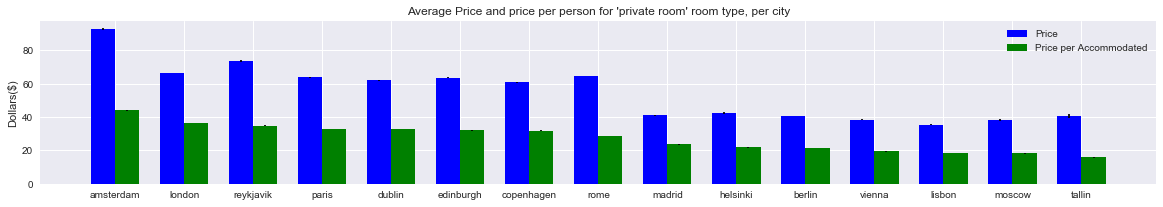

In [17]:
#creating bar chart showing the average prices and average prices per accommodated for all room types, per city
plt.clf()
N = len(datasets.keys())
price_means = []
price_stds = []
price_per_accommodated_means = []
price_per_accommodated_stds = []
cities = []

for city in datasets.keys():
    city_data = datasets[city]
    city_data = city_data[city_data['room_type'] == 'Private room']
    price_means.append(city_data['price'].mean())
    price_stds.append(2 * float(city_data['price'].std()/np.sqrt(len(city_data))))
    price_per_accommodated_means.append(city_data['price_per_accommodated'].mean())
    price_per_accommodated_stds.append(2 * float(city_data['price_per_accommodated'].std()/np.sqrt(len(city_data))))
    cities.append(city)


sort_indices = np.argsort(np.asarray(price_per_accommodated_means)) #sort cities on price per accommodated
price_means = list(np.asarray(price_means)[sort_indices[::-1]])
price_stds = list(np.asarray(price_stds)[sort_indices[::-1]])
price_per_accommodated_means = list(np.asarray(price_per_accommodated_means)[sort_indices[::-1]])
price_per_accommodated_stds = list(np.asarray(price_per_accommodated_stds)[sort_indices[::-1]])
cities = list(np.asarray(cities)[sort_indices[::-1]])


pos = np.arange(N)
width = 0.35

fig, ax = plt.subplots(figsize=(20,3))

prices_bar = ax.bar(pos, tuple(price_means), width, color='b', yerr=tuple(price_stds))
prices_pa_bar = ax.bar(pos+width, tuple(price_per_accommodated_means), width, 
                       color='g', yerr=tuple(price_per_accommodated_stds))

ax.legend((prices_bar[0], prices_pa_bar[0]), ('Price', 'Price per Accommodated'))

ax.set_ylabel('Dollars($)')
ax.set_title('Average Price and price per person for \'private room\' room type, per city')
ax.set_xticks(pos + width / 2)
ax.set_xticklabels(tuple(cities))

plt.show()


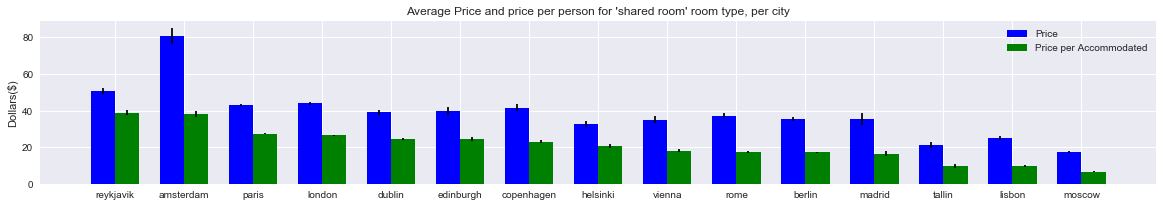

In [18]:
#creating bar chart showing the average prices and average prices per accommodated for all room types, per city
plt.clf()
N = len(datasets.keys())
price_means = []
price_stds = []
price_per_accommodated_means = []
price_per_accommodated_stds = []
cities = []

for city in datasets.keys():
    city_data = datasets[city]
    city_data = city_data[city_data['room_type'] == 'Shared room']
    price_means.append(city_data['price'].mean())
    price_stds.append(2 * float(city_data['price'].std()/np.sqrt(len(city_data))))
    price_per_accommodated_means.append(city_data['price_per_accommodated'].mean())
    price_per_accommodated_stds.append(2 * float(city_data['price_per_accommodated'].std()/np.sqrt(len(city_data))))
    cities.append(city)


sort_indices = np.argsort(np.asarray(price_per_accommodated_means)) #sort cities on price per accommodated
price_means = list(np.asarray(price_means)[sort_indices[::-1]])
price_stds = list(np.asarray(price_stds)[sort_indices[::-1]])
price_per_accommodated_means = list(np.asarray(price_per_accommodated_means)[sort_indices[::-1]])
price_per_accommodated_stds = list(np.asarray(price_per_accommodated_stds)[sort_indices[::-1]])
cities = list(np.asarray(cities)[sort_indices[::-1]])


pos = np.arange(N)
width = 0.35

fig, ax = plt.subplots(figsize=(20,3))

prices_bar = ax.bar(pos, tuple(price_means), width, color='b', yerr=tuple(price_stds))
prices_pa_bar = ax.bar(pos+width, tuple(price_per_accommodated_means), width, 
                       color='g', yerr=tuple(price_per_accommodated_stds))

ax.legend((prices_bar[0], prices_pa_bar[0]), ('Price', 'Price per Accommodated'))

ax.set_ylabel('Dollars($)')
ax.set_title('Average Price and price per person for \'shared room\' room type, per city')
ax.set_xticks(pos + width / 2)
ax.set_xticklabels(tuple(cities))

plt.show()

In [19]:
#convert last modified column to datetime
for city in datasets.keys():
    city_data = datasets[city]
    city_data['last_modified'] = pd.to_datetime(city_data['last_modified'])
    city_data = city_data.sort_values(by='last_modified',ascending=True)
    datasets[city] = city_data.reset_index()
    

Using the most frequent room_ids per room type per city, changes in their price and price_per_accommodated columns are plotted through time. In some occasions the price changes seem to be identical for all the rooms, thus a trend can be reported. With the use of more rooms and the use of significant tests we can make significant assumptions regarding the existence of such a trend.

In [20]:
#obtain the room_ids with most frequencies per city and per room_type
N = 7 #number of most frequent room_ids we are going to use
room_types = data.groupby(['room_type']).groups.keys() #get all room_types
city_room_data = [] #containing the lists of most frequent rooms_ids per room_type per city
for city in cities: #used insead of simple dict iteration so that it is guaranteed that we always have the same order
    data = datasets[city]
    city_room = [] #containing the lists of most frequent room ids per room type
    for rt in room_types:
        gb = data[data['room_type'] == rt].groupby(['room_id']) #group by rooms_ids of a particular room_type
        city_room.append(list(gb['room_id'].count().sort_values(ascending=False).to_frame().index[:N].values.tolist()))
        #getting the first three room_ids with the biggest frequency per room_type
    city_room_data.append(city_room)
        

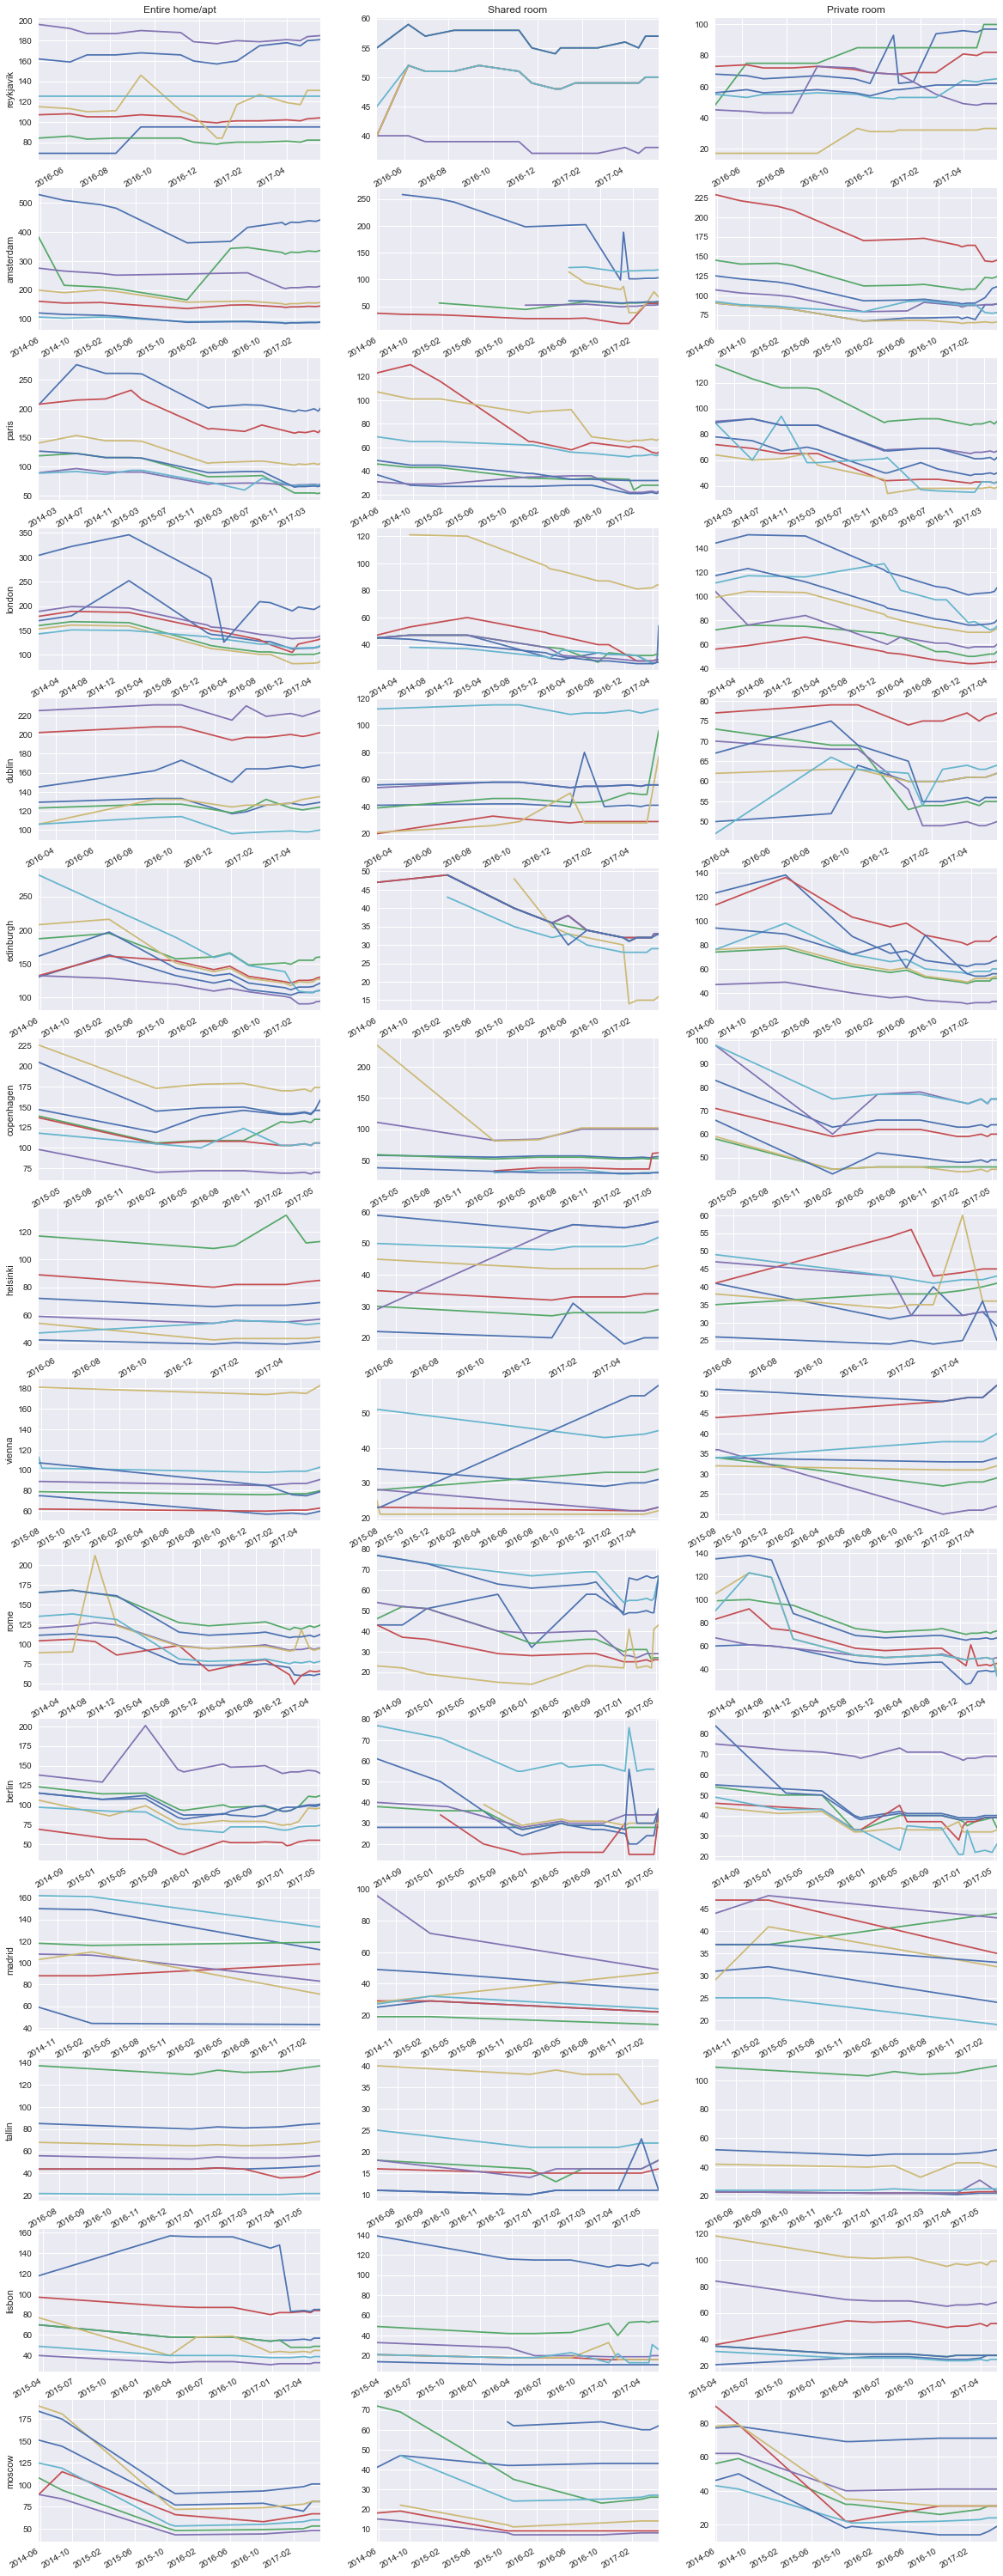

In [21]:
#plotting the price changes per time for the most frequent room_ids per city through time
plt.clf()
fig, ax = plt.subplots(len(datasets.keys()),len(room_types), figsize=(20,60))
i = 0
for city in cities:
    data = datasets[city]
    data = data.set_index('last_modified')
    for j in range(len(room_types)):
        for rid in city_room_data[i][j]: #for each room id of ith city and jth room type
            data[data['room_id'] == rid]['price'].plot(ax=ax[i][j])
            ax[i][j].xaxis.label.set_visible(False)
    
    i += 1
[ax[i][0].set_ylabel(cities[i]) for i in range(len(cities))]
[ax[0][j].set_title(room_types[j]) for j in range(len(room_types))]
plt.show()

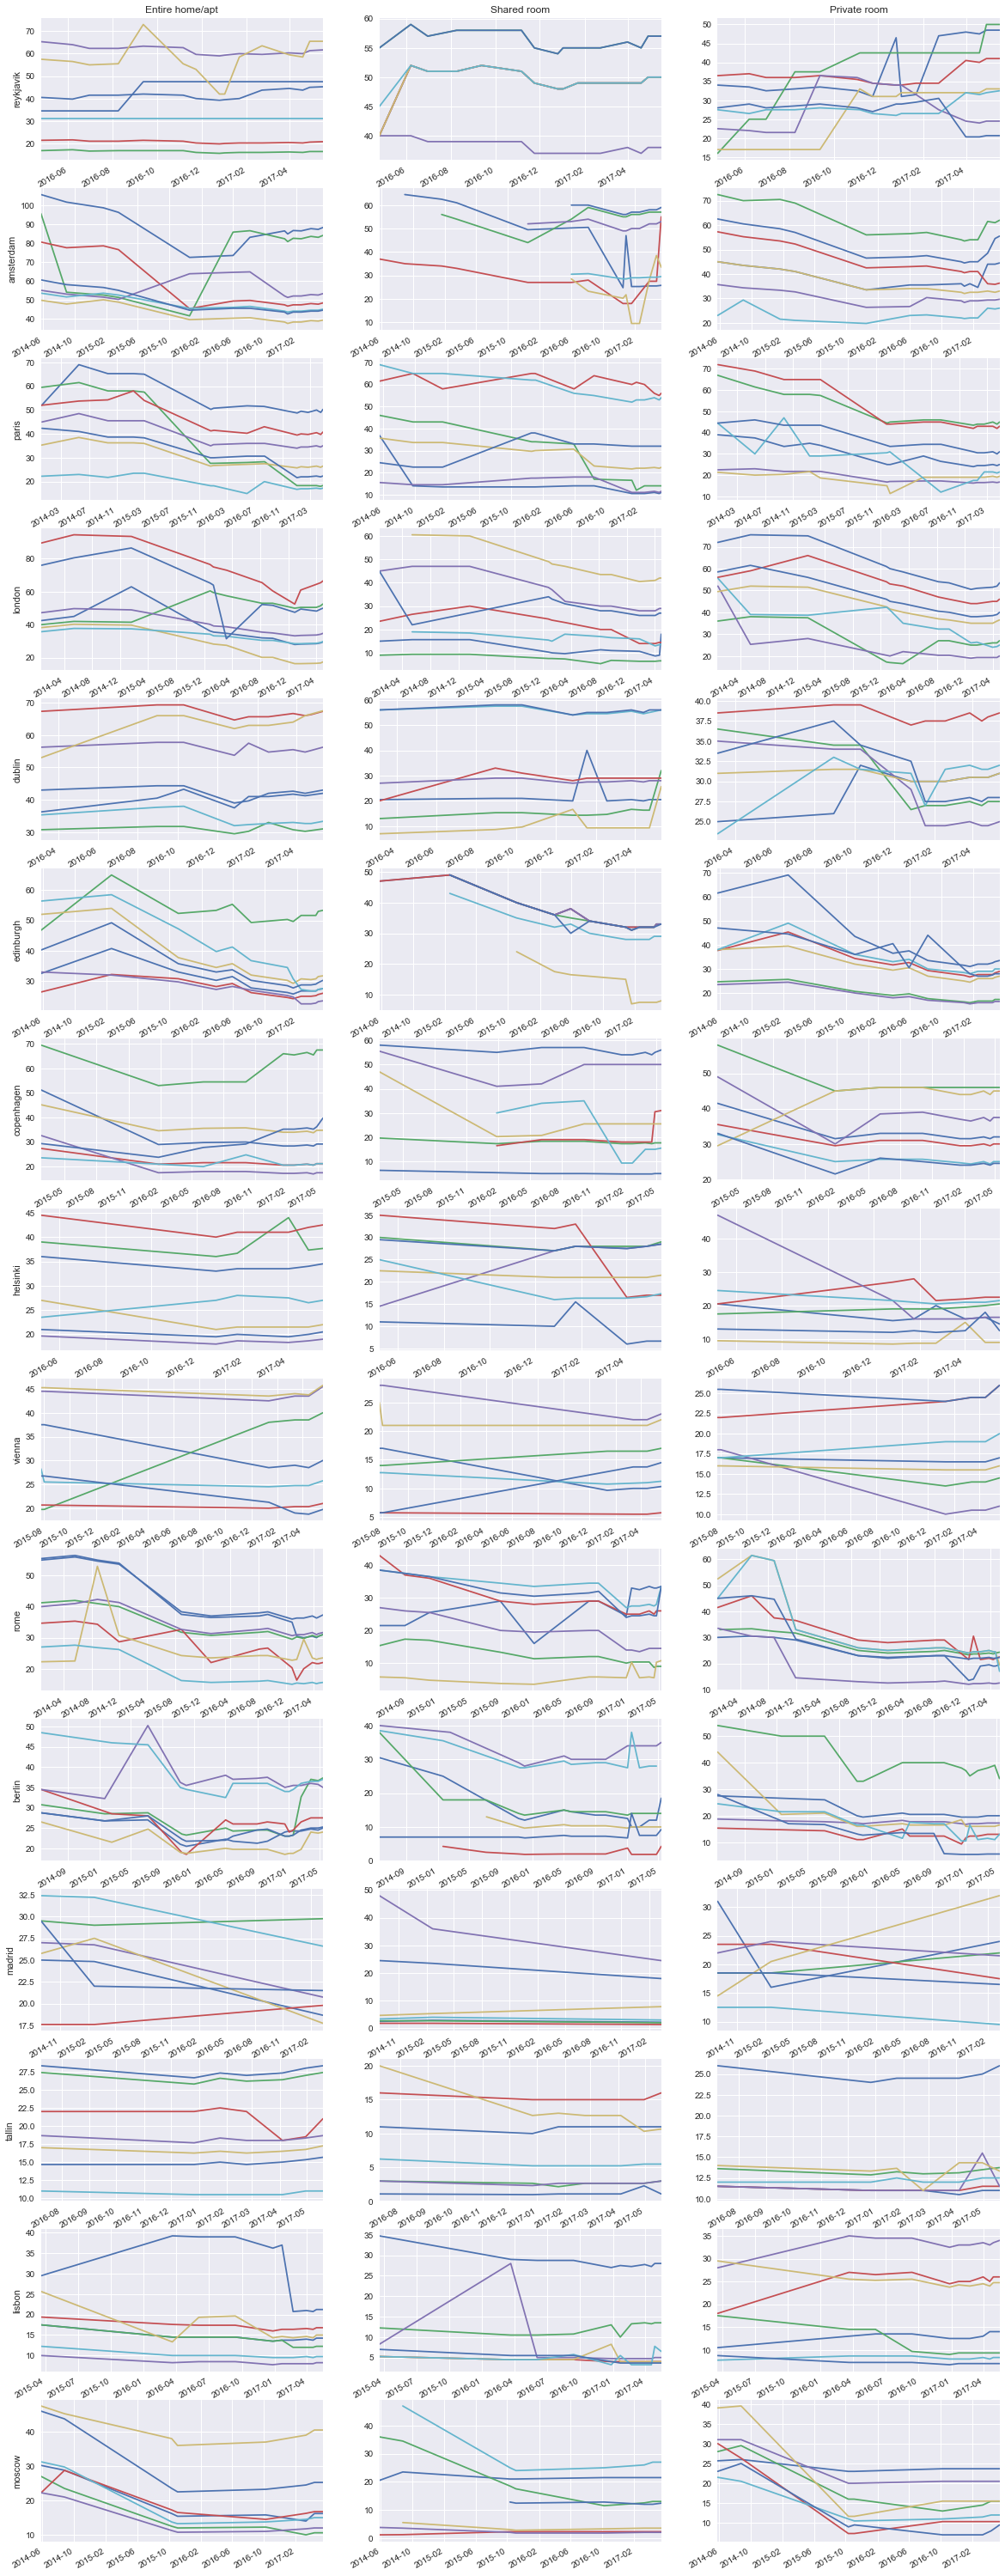

In [22]:
#plotting the price_per_accommodated changes per time for the most frequent room_ids per room_type per city through time
plt.clf()
fig, ax = plt.subplots(len(datasets.keys()),len(room_types), figsize=(20,60))
i = 0
for city in cities:
    data = datasets[city]
    data = data.set_index('last_modified')
    for j in range(len(room_types)):
        for rid in city_room_data[i][j]: #for each room id of ith city and jth room type
            data[data['room_id'] == rid]['price_per_accommodated'].plot(ax=ax[i][j])
            ax[i][j].xaxis.label.set_visible(False)
    
    i += 1
[ax[i][0].set_ylabel(cities[i]) for i in range(len(cities))]
[ax[0][j].set_title(room_types[j]) for j in range(len(room_types))]
plt.show()

The changes in the average price and price_per_accommodated through the different years is presented. If the crawlings had happened for a fixed number of times and to fixed time periods per year it would be easier to make assumptions about the trends followed. For example the price differences between two years might not be caused by the change of year but by the fact that the first data collection took place in the summer and the next in the winter. If I had more time I would separate the time periods per season('summer','spring','winter'), too. 

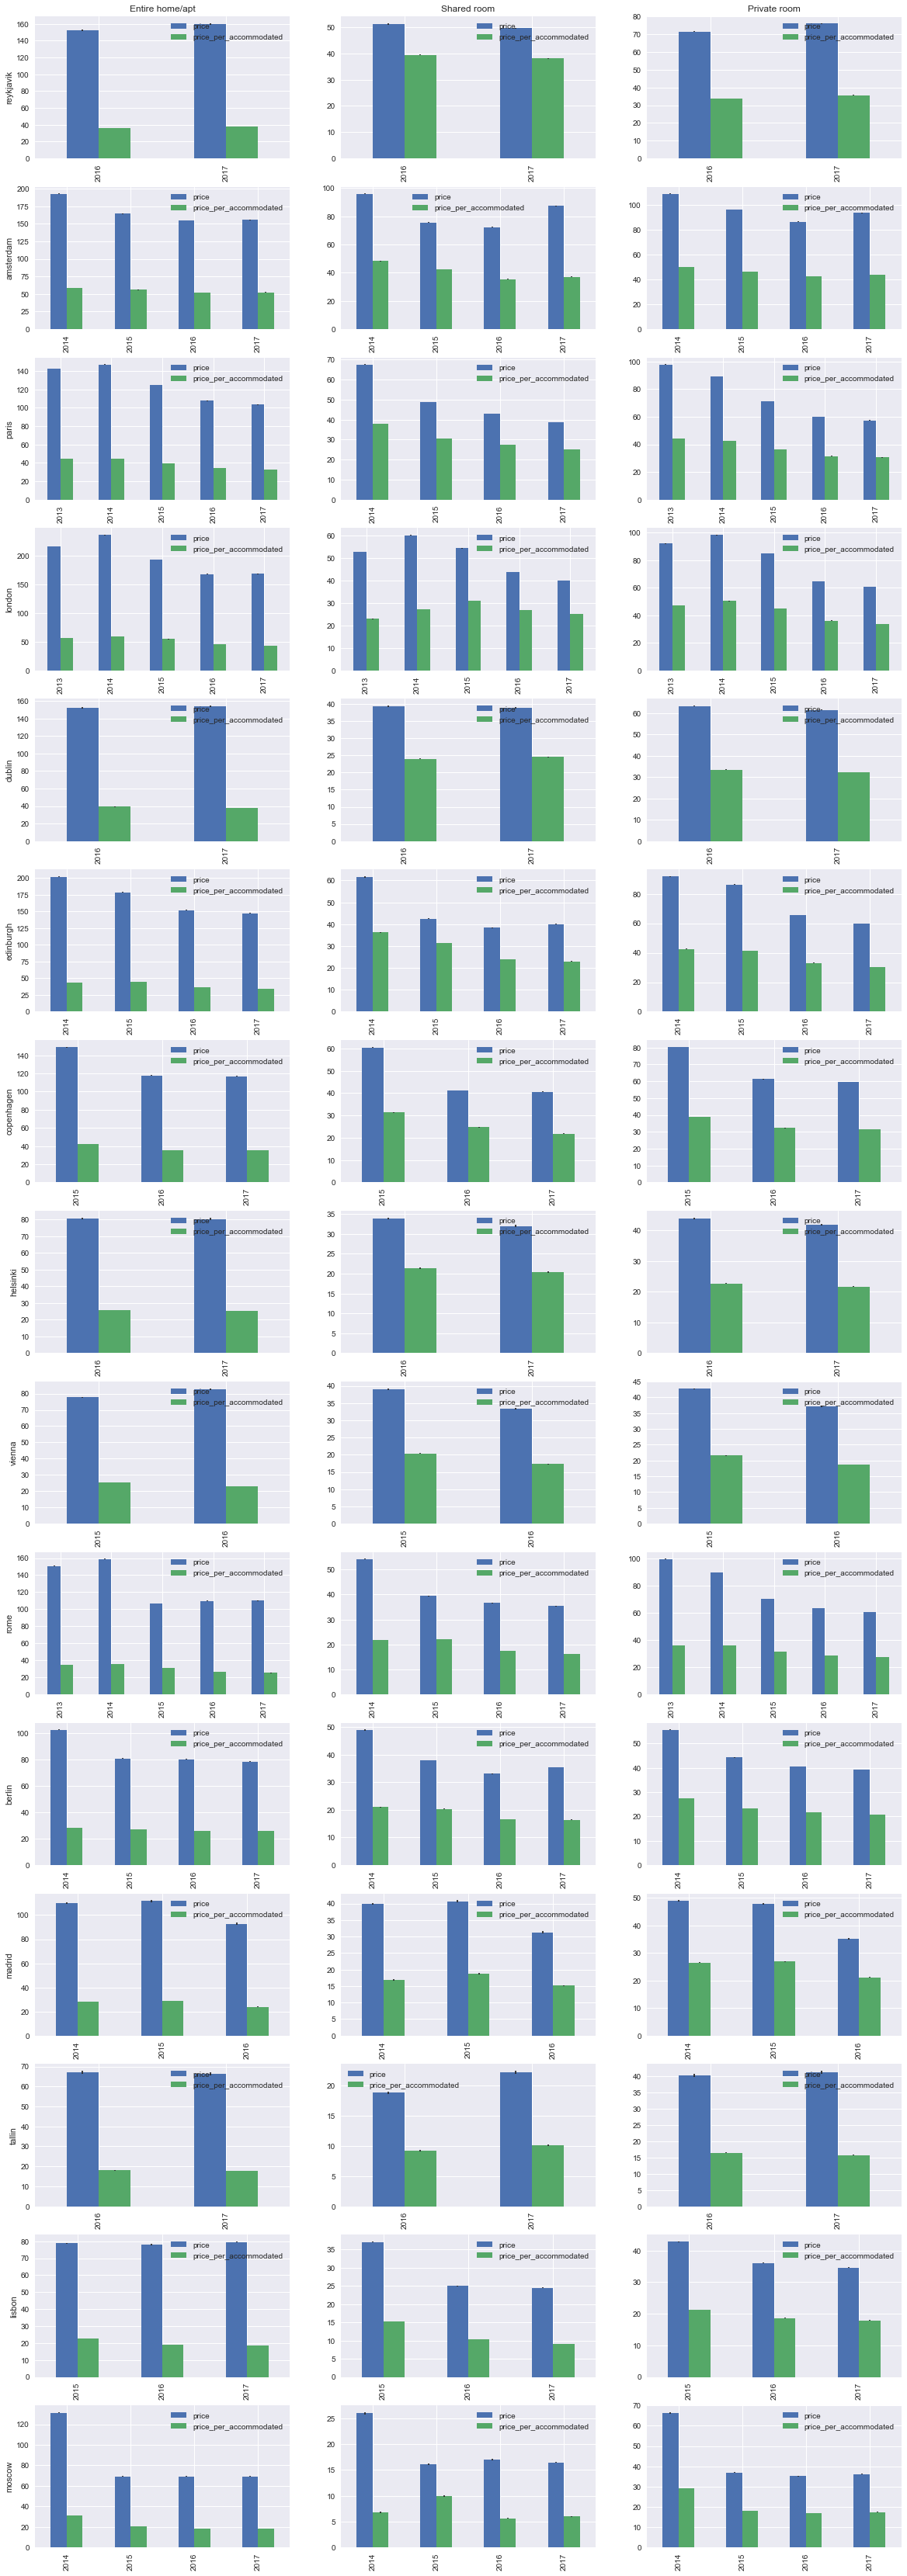

In [34]:
#plotting the price and price_per_accommodated means'changes from year to year per room type and per city
plt.clf()
fig, ax = plt.subplots(len(datasets.keys()),len(room_types), figsize=(20,60))
i = 0
for city in cities:
    data = datasets[city]
    data = data.set_index('last_modified')
    for j in range(len(room_types)):
        means = data[data['room_type'] == room_types[j]][['price','price_per_accommodated']].resample('A').mean()
        stds = data[data['room_type'] == room_types[j]][['price','price_per_accommodated']].resample('A').std()
        stds = stds.apply(lambda x: 2 * (x/np.sqrt(len(data))))
        #print(stds)
        means.dropna().plot.bar(yerr=stds,ax=ax[i][j])
        ax[i][j].set_xticklabels(tuple([str(label).split('-')[0] for label in list(means.index)]))
        ax[i][j].xaxis.label.set_visible(False)
        
    
    i += 1
[ax[i][0].set_ylabel(cities[i]) for i in range(len(cities))]
[ax[0][j].set_title(room_types[j]) for j in range(len(room_types))]
plt.show()
        

In [266]:
datasets['paris'].sample(5)

,level_0,index,accommodates,bedrooms,host_id,last_modified,latitude,longitude,neighborhood,price,reviews,room_id,room_type,price_per_accommodated
206603,212029,220315,16.0,1.0,43921623.0,2016-05-27 18:40:52.429502,48.859494,2.369537,Saint-Ambroise,280.0,0,10579046,Entire home/apt,17.500000
134922,133422,134584,4.0,1.0,6477468.0,2015-12-19 03:41:48.129612,48.875754,2.380927,Combat,89.0,0,1199265,Entire home/apt,22.250000
551668,614926,623301,2.0,0.0,96624462.0,2017-04-16 05:28:54.889635,48.855130,2.403524,Charonne,49.0,11,15210306,Entire home/apt,24.500000
214031,209687,217967,2.0,1.0,35203.0,2016-05-27 23:31:02.034295,48.861654,2.353438,Saint-Avoye,109.0,11,12112,Private room,54.500000
584725,581511,589886,6.0,2.0,15328681.0,2017-04-17 00:30:20.287271,48.831400,2.355478,Croulebarbe,121.0,2,12046575,Entire home/apt,20.166667


In [267]:
#checking the diversity in the nominal columns
#wherever there is only one value the column is deleted 
nominal_position_columns = ['neighborhood','borough']

for city in datasets.keys():
    data = datasets[city]
    for col in nominal_position_columns:
        if col in set(data.columns):
            num = len(data.groupby([col]).groups)
            print('\n{}: There are {} different {}s'.format(city,num,col))
            if num < 2:
                data.drop([col], axis=1, inplace=True)
                print('Column {} was deleted from {}\'s dataset'.format(col,city))
    datasets[city] = data
                    
                


edinburgh: There are 58 different neighborhoods

reykjavik: There are 1 different neighborhoods
Column neighborhood was deleted from reykjavik's dataset

helsinki: There are 51 different neighborhoods

paris: There are 80 different neighborhoods

madrid: There are 128 different neighborhoods

madrid: There are 21 different boroughs

moscow: There are 117 different neighborhoods

moscow: There are 1 different boroughs
Column borough was deleted from moscow's dataset

dublin: There are 1 different neighborhoods
Column neighborhood was deleted from dublin's dataset

tallin: There are 1 different neighborhoods
Column neighborhood was deleted from tallin's dataset

berlin: There are 12 different neighborhoods

rome: There are 19 different neighborhoods

london: There are 594 different neighborhoods

london: There are 33 different boroughs

lisbon: There are 24 different neighborhoods

amsterdam: There are 23 different neighborhoods

copenhagen: There are 10 different neighborhoods

vienna:

In [268]:
#finding out the percentage of the rooms that are presented to have 0 bedrooms
for city,data in datasets.iteritems():
    print('{}% of {}\'s rooms are presented to have zero bedrooms'.format(
        100 * len(data[data['bedrooms'] == 0]) / len(data.index),city))

1.49795471568% of edinburgh's rooms are presented to have zero bedrooms
5.30674131094% of reykjavik's rooms are presented to have zero bedrooms
20.7735092485% of helsinki's rooms are presented to have zero bedrooms
19.3744841482% of paris's rooms are presented to have zero bedrooms
6.49476006619% of madrid's rooms are presented to have zero bedrooms
4.80002521353% of moscow's rooms are presented to have zero bedrooms
2.15972469443% of dublin's rooms are presented to have zero bedrooms
16.0266950382% of tallin's rooms are presented to have zero bedrooms
4.40810522574% of berlin's rooms are presented to have zero bedrooms
3.69503966783% of rome's rooms are presented to have zero bedrooms
4.67028252046% of london's rooms are presented to have zero bedrooms
5.44763589753% of lisbon's rooms are presented to have zero bedrooms
5.42078719748% of amsterdam's rooms are presented to have zero bedrooms
1.91382738607% of copenhagen's rooms are presented to have zero bedrooms
7.80183542524% of vien

Given the fact that each city contains a great number of neighborhoods and boroughs, it is considered that using these columns (by hot-encoding them) would increase the dimensionality of out dataset dramatically. As a result, it was decided that discarding these columns and use only the information provided by the latitudes and the longitudes would be a wiser choice.
Regarding the bedrooms, we see that, for most datasets, the number of the rooms reported to offer 0 bedrooms was limited.  Using cross-validation score afterwards, it was reported that the model performed better if these were treated as bad values and were discarded. Consequently, even if it is not perfectly clear if the zero value is a false value for this column, the rows containing it were deleted.

# 3. Feature Engineering and further data processing

In [269]:
#mapping latitude and longitude to three dimensions(sphere) so that they can be standardized
#also transforming datetime to timestamp
new_datasets = dict() #containing he new data which only contain the 
for city in datasets.keys():
    data = datasets[city]
    new_data = data
    new_data['x'] = np.cos(new_data['latitude']) * np.cos(new_data['longitude'])
    new_data['y'] = np.cos(new_data['latitude']) * np.sin(new_data['longitude'])
    new_data['z'] = np.sin(new_data['latitude'])
    new_data = new_data.drop(['latitude','longitude'],axis=1) #deleting former coordinates
    for col in nominal_position_columns:
        if col in set(new_data.columns):
            new_data = new_data.drop([col],axis=1) #deleting nominal position features
    print('{}\'s coordinates system was transformed'.format(city))
    new_datasets[city] = new_data #inserted into new data dictionary

edinburgh's coordinates system was transformed
reykjavik's coordinates system was transformed
helsinki's coordinates system was transformed
paris's coordinates system was transformed
madrid's coordinates system was transformed
moscow's coordinates system was transformed
dublin's coordinates system was transformed
tallin's coordinates system was transformed
berlin's coordinates system was transformed
rome's coordinates system was transformed
london's coordinates system was transformed
lisbon's coordinates system was transformed
amsterdam's coordinates system was transformed
copenhagen's coordinates system was transformed
vienna's coordinates system was transformed


In [270]:
#converting datetimes to timedeltas so that they can be standardized
for city in new_datasets.keys():
    data = new_datasets[city]
    data['last_modified'] = pd.to_timedelta(
    data['last_modified']).apply(lambda x: str(x).split()[0])
    print('{}\'s datetimes were converted to timedeltas'.format(city))
    new_datasets[city] = data


edinburgh's datetimes were converted to timedeltas
reykjavik's datetimes were converted to timedeltas
helsinki's datetimes were converted to timedeltas
paris's datetimes were converted to timedeltas
madrid's datetimes were converted to timedeltas
moscow's datetimes were converted to timedeltas
dublin's datetimes were converted to timedeltas
berlin's datetimes were converted to timedeltas
tallin's datetimes were converted to timedeltas
rome's datetimes were converted to timedeltas
london's datetimes were converted to timedeltas
lisbon's datetimes were converted to timedeltas
amsterdam's datetimes were converted to timedeltas
copenhagen's datetimes were converted to timedeltas
vienna's datetimes were converted to timedeltas


In [271]:
#dropping room_id,host_id and other unused for the model to construct columns
#moreover room_type columns gets one-hot encoded
columns_to_drop = ['level_0','index','room_id','host_id','price_per_accommodated']
columns_to_onehot = ['room_type']

for city in new_datasets.keys():
    data = new_datasets[city]
    for col in columns_to_drop: #drop columns_to_drop
        if col in set(data.columns):
            data = data.drop([col],axis=1)
    for col in columns_to_onehot: #replace columns_to_onehot with their binary encoding
        if col in set(data.columns):
            one_hot_col = pd.get_dummies(data[col]) 
            data = data.join(one_hot_col)
            data = data.drop([col],axis=1) 
    print('Column deletes and replacements were completed for {}\'s dataset'.format(city))
    new_datasets[city] = data
    


Column deletes and replacements were completed for edinburgh's dataset
Column deletes and replacements were completed for reykjavik's dataset
Column deletes and replacements were completed for helsinki's dataset
Column deletes and replacements were completed for paris's dataset
Column deletes and replacements were completed for madrid's dataset
Column deletes and replacements were completed for moscow's dataset
Column deletes and replacements were completed for dublin's dataset
Column deletes and replacements were completed for berlin's dataset
Column deletes and replacements were completed for tallin's dataset
Column deletes and replacements were completed for rome's dataset
Column deletes and replacements were completed for london's dataset
Column deletes and replacements were completed for lisbon's dataset
Column deletes and replacements were completed for amsterdam's dataset
Column deletes and replacements were completed for copenhagen's dataset
Column deletes and replacements were

In [272]:
#deleting rooms with bedrooms = 0
for city in new_datasets:
    data = new_datasets[city]
    print('{}% of {}\'s rooms are discarded'.format(
        100 * len(data[data['bedrooms'] == 0]) / len(data.index),city))
    data = data.drop(data[data['bedrooms'] == 0].index)
    new_datasets[city] = data

1.49795471568% of edinburgh's rooms are discarded
5.30674131094% of reykjavik's rooms are discarded
20.7735092485% of helsinki's rooms are discarded
19.3744841482% of paris's rooms are discarded
6.49476006619% of madrid's rooms are discarded
4.80002521353% of moscow's rooms are discarded
2.15972469443% of dublin's rooms are discarded
4.40810522574% of berlin's rooms are discarded
16.0266950382% of tallin's rooms are discarded
3.69503966783% of rome's rooms are discarded
4.67028252046% of london's rooms are discarded
5.44763589753% of lisbon's rooms are discarded
5.42078719748% of amsterdam's rooms are discarded
1.91382738607% of copenhagen's rooms are discarded
7.80183542524% of vienna's rooms are discarded


In [273]:
#transfering price to separate unit-column dataframe
prices = dict() #containing the price column (that is going to be predicted) for each city
for city in new_datasets.keys():
    data = new_datasets[city]
    price_data = pd.DataFrame()
    price_data['price'] = data['price']
    data = data.drop(['price'],axis=1)
    prices[city] = price_data
    new_datasets[city] = data
    


In [274]:
prices['madrid'].sample(5)

,price
1115,29.0
1165,29.0
13663,66.0
11102,22.0
1269,52.0


In [275]:
new_datasets['reykjavik'].sample(5)

,accommodates,bedrooms,last_modified,reviews,x,y,z,Entire home/apt,Private room,Shared room
42291,4,2.0,17302,0,-0.250929,-0.007114,0.967979,1,0,0
35842,4,1.0,17275,24,-0.249613,-0.007737,0.968315,1,0,0
28313,2,1.0,17219,4,-0.249860,-0.011310,0.968216,0,1,0
3087,5,3.0,16958,10,-0.251418,-0.010388,0.967823,1,0,0
10458,2,1.0,17021,22,-0.258911,-0.017913,0.965735,1,0,0


# 4. Building and Evaluating model

The following strategy was followed: Each city's dataset was initially separated to a training and a test set after being shuffled. Afterwards, the training set of each city was transformed to 3 training-validation pairs so that 3-fold cross-validation was performed. Linear regression, Multi-Layer Perceptron regression as well as Random Forest regression were used, with a fixed random_state so that the results were reproducible. No hyper-parameter tuning was performed due to lack of time (except from checking the impact of the zero-bedroom issue referred above). For most of the cities the Random Forest Regressor performed significantly better. Consequently, afterwards, I used the whole training dataset and Random Forest Regression to evaluate my model on the test set. If I had more time, pair-wise tests would be a more formal way to perform model selection, while I would also be able to explore with plots and more in depth the correlation between the different features of the dataset. 

In [276]:
#splitting each cities dataset to training and test set
training_datasets = dict() #containing the training sets of each city
training_prices = dict() #containing the targets of the training set of each city
test_datasets = dict() #containing the test sets of each city
test_prices = dict() #containing the targets of the test set of each city

for city in new_datasets.keys():
    X = new_datasets[city]
    y = prices[city]
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=random_state)
    training_datasets[city] = X_train
    training_prices[city] = y_train
    test_datasets[city] = X_test
    test_prices[city] = y_test
    print('{}:\tInitial size:\t{}\tTraining set size:\t{}\tTest set size:\t{}'.format(city,len(X.index),len(X_train.index),
                                                                                len(X_test.index)))




edinburgh:	Initial size:	68388	Training set size:	54710	Test set size:	13678
reykjavik:	Initial size:	40595	Training set size:	32476	Test set size:	8119
helsinki:	Initial size:	12250	Training set size:	9800	Test set size:	2450
paris:	Initial size:	531406	Training set size:	425124	Test set size:	106282
madrid:	Initial size:	20343	Training set size:	16274	Test set size:	4069
moscow:	Initial size:	30206	Training set size:	24164	Test set size:	6042
dublin:	Initial size:	57715	Training set size:	46172	Test set size:	11543
berlin:	Initial size:	220498	Training set size:	176398	Test set size:	44100
tallin:	Initial size:	8682	Training set size:	6945	Test set size:	1737
rome:	Initial size:	259773	Training set size:	207818	Test set size:	51955
london:	Initial size:	461025	Training set size:	368820	Test set size:	92205
lisbon:	Initial size:	104747	Training set size:	83797	Test set size:	20950
amsterdam:	Initial size:	167845	Training set size:	134276	Test set size:	33569
copenhagen:	Initial size:	

In [277]:
training_datasets['helsinki']

,accommodates,bedrooms,last_modified,reviews,x,y,z,Entire home/apt,Private room,Shared room
15034,4,1.0,17304,8,-0.872163,0.179278,-0.455182,1,0,0
7026,2,1.0,17189,1,-0.864580,0.164098,-0.474946,0,0,1
12091,6,3.0,17284,2,-0.838292,0.167851,-0.518741,1,0,0
14992,4,1.0,17304,44,-0.871160,0.182169,-0.455956,1,0,0
2607,2,1.0,17161,1,-0.846832,0.110702,-0.520212,1,0,0
1215,2,1.0,16928,0,-0.861121,0.144589,-0.487406,0,1,0
1236,3,2.0,16928,4,-0.868670,0.146567,-0.473213,1,0,0
13097,2,1.0,17304,11,-0.870770,0.191264,-0.452966,0,1,0
1846,6,2.0,16928,5,-0.871242,0.184965,-0.454670,1,0,0
5962,5,3.0,17189,5,-0.836008,0.183995,-0.516950,1,0,0


In [278]:
#Initializing 3-fold cross-validation
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)

In [279]:
#generating 3 training-validation set pairs from each city's training set
X_trains = dict() #containing the list of the training sets per city
X_vals = dict() #containing the list of the validation sets per city
y_trains = dict() #containing the list of the training sets' targets per city
y_vals = dict() #containing the list of the validation sets' targets per city

for city in training_datasets.keys():
    X = training_datasets[city]
    y = training_prices[city]
    X_trs = [] #the list of the training sets per city
    X_vs = [] #the list of the validation sets per city
    y_trs = [] #the list of the training sets' targets per city
    y_vs = [] #the list of the validation sets' targets per city
    for train_index, val_index in cv.split(X): #splitting to training and validation set
        X_trs.append(X.iloc[train_index])
        y_trs.append(y.iloc[train_index])
        X_vs.append(X.iloc[val_index])
        y_vs.append(y.iloc[val_index])
    X_trains[city] = X_trs
    X_vals[city] = X_vs
    y_trains[city] = y_trs
    y_vals[city] = y_vs
    print('{}:\tInitial size of training data:\t{}\tTraining sets\' size:\t{}\tValidation sets\' size:\t{}'.format(city,len(X.index),len(X_trs[0].index),
                                                                                len(X_vs[0].index)))


edinburgh:	Initial size of training data:	54710	Training sets' size:	36473	Validation sets' size:	18237
reykjavik:	Initial size of training data:	32476	Training sets' size:	21650	Validation sets' size:	10826
helsinki:	Initial size of training data:	9800	Training sets' size:	6533	Validation sets' size:	3267
paris:	Initial size of training data:	425124	Training sets' size:	283416	Validation sets' size:	141708
madrid:	Initial size of training data:	16274	Training sets' size:	10849	Validation sets' size:	5425
moscow:	Initial size of training data:	24164	Training sets' size:	16109	Validation sets' size:	8055
dublin:	Initial size of training data:	46172	Training sets' size:	30781	Validation sets' size:	15391
tallin:	Initial size of training data:	6945	Training sets' size:	4630	Validation sets' size:	2315
berlin:	Initial size of training data:	176398	Training sets' size:	117598	Validation sets' size:	58800
rome:	Initial size of training data:	207818	Training sets' size:	138545	Validation sets

In [280]:
y_trains['paris'][0].head(5)

,price
18735,100.0
523508,108.0
204822,58.0
388896,71.0
23486,92.0


In [281]:
#standardizing the non-binary features as well as the targets(price)

for city in X_trains.keys():
    X_trs = X_trains[city]
    X_vs = X_vals[city]
    y_trs = y_trains[city]
    y_vs = y_vals[city]
    X_columns = list(X_trs[0]) #holdinh the column names of the dataset
    y_column = list(y_trs[0]) #holding the column name of the targets
    X_trs_sc = [] #they are going to host the standardized versions
    X_vs_sc = []
    y_trs_sc = []
    y_vs_sc = []
    stand_columns = [col for col in X_columns if col not in set(room_types)] 
    #holding the names of the columns to be standardized
        
    
    for i in range(len(X_trs)):
        X_tr_index = list(X_trs[i].index) #holding the index of the particular cross-validation split
        X_v_index = list(X_vs[i].index) #holding the index of the particular cross-validation split
        X_tr_stand = X_trs[i][stand_columns] #holding the features to be standardized
        X_v_stand = X_vs[i][stand_columns] #holding the features to be standardized
        X_tr = X_trs[i].drop(stand_columns,axis=1) #holding only the binary columns
        X_v = X_vs[i].drop(stand_columns,axis=1) #holding only the binary columns
        non_stand_columns = list(X_tr.columns) #holding the names of the binary columns
        X_sc = StandardScaler().fit(X_tr_stand) 
        X_tr_stand = X_sc.transform(X_tr_stand) #standardization of the training set
        X_v_stand = X_sc.transform(X_v_stand) #standardization of the validation set using the model trained on 
                                                    #the training set
        X_tr = np.c_[X_tr_stand,X_tr] #uniting standardized features with binary features
        X_v = np.c_[X_v_stand,X_v] #uniting standardized features with binary features
            
        X_trs_sc.append(pd.DataFrame(X_tr,columns=stand_columns+non_stand_columns,index=X_tr_index))
        X_vs_sc.append(pd.DataFrame(X_v,columns=stand_columns+non_stand_columns,index=X_v_index))
        
        y_tr = y_trs[i].values
        y_v = y_vs[i].values
        y_sc = StandardScaler().fit(y_tr) 
        y_tr = y_sc.transform(y_tr) #standardization of the training targets
        y_v = y_sc.transform(y_v) #standardization of the validation targets using training targets' model
        y_trs_sc.append(pd.DataFrame(y_tr,columns=y_column,index=X_tr_index))
        y_vs_sc.append(pd.DataFrame(y_v,columns=y_column,index=X_v_index))
    
    #replace the old form of the datasets with the standardized version of them
    X_trains[city] = X_trs_sc 
    X_vals[city] = X_vs_sc
    y_trains[city] = y_trs_sc
    y_vals[city] = y_vs_sc
    
    print('{}\'s data were standardized'.format(city))

        
        

edinburgh's data were standardized
reykjavik's data were standardized
helsinki's data were standardized
paris's data were standardized
madrid's data were standardized
moscow's data were standardized
dublin's data were standardized
berlin's data were standardized
tallin's data were standardized
rome's data were standardized
london's data were standardized
lisbon's data were standardized
amsterdam's data were standardized
copenhagen's data were standardized
vienna's data were standardized


In [282]:
#Performing stability selection (trying to estimate the value of each ferature as far as the regression is concerned)
#input: X_trains_sc --> list of standardized training sets
#       y_trains_sc --> list of standardized training targets
#output: list containing the mean and standard deviation of the metric 
def get_features_importance(X_trains_sc,y_trains_sc,selection_threshold=0.25):
    rlasso = RandomizedLasso(random_state=random_state,selection_threshold=selection_threshold)
    cv_scores = []
    for i in range(len(X_trains_sc)):
        rlasso.fit(X_trains_sc[i],y_trains_sc[i].values.ravel())
        cv_scores.append(rlasso.scores_)
    cv_scores = np.asarray(cv_scores)
    cv_scores = np.vstack(cv_scores) #list of arrays to array
    return [list(np.mean(cv_scores,axis=0)),list(np.std(cv_scores,axis=0))]
    #returning a list containing the list containing the means and the stds of the metric per feature
    



In [283]:
#Performing Linear Regression
#input: X_trains_sc --> list of standardized training sets
#       y_trains_sc --> list of standardized training targets
#       X_vals_sc --> list of standardized validation sets
#       y_vals_sc --> list of standardized validation targets
#output: list containing the means and standard deviations of regression evaluation metrics 
def get_linear_regression(X_trains_sc,y_trains_sc,X_vals_sc,y_vals_sc):
    lr = LinearRegression()
    cv_mses = []
    cv_maes = []
    cv_r2s = []
    for i in range(len(X_trains_sc)):
        lr.fit(X_trains_sc[i],y_trains_sc[i].values.ravel())
        y_pred = lr.predict(X_vals_sc[i])
        cv_mses.append(math.sqrt(mean_squared_error(y_vals_sc[i],y_pred)))
        cv_maes.append(mean_absolute_error(y_vals_sc[i],y_pred))
        cv_r2s.append(r2_score(y_vals_sc[i],y_pred))
    cv_mses = np.asarray(cv_mses)
    cv_maes = np.asarray(cv_maes)
    cv_r2s = np.asarray(cv_r2s)
    
    rmse = [np.mean(cv_mses),np.std(cv_mses)] #list containing the mean and the std of the particular metric
    mae = [np.mean(cv_maes),np.std(cv_maes)]
    r2 = [np.mean(cv_r2s),np.std(cv_r2s)]
    return [rmse,mae,r2] #returning the metrics

In [284]:
#Performing Multi Layer Perceptron Regression
#input: X_trains_sc --> list of standardized training sets
#       y_trains_sc --> list of standardized training targets
#       X_vals_sc --> list of standardized validation sets
#       y_vals_sc --> list of standardized validation targets
#output: list containing the means and standard deviations of regression evaluation metrics 
def get_mlp_regression(X_trains_sc,y_trains_sc,X_vals_sc,y_vals_sc):
    mlpr = MLPRegressor(random_state=random_state)
    cv_mses = []
    cv_maes = []
    cv_r2s = []
    for i in range(len(X_trains_sc)):
        mlpr.fit(X_trains_sc[i],y_trains_sc[i].values.ravel())
        y_pred = mlpr.predict(X_vals_sc[i])
        cv_mses.append(math.sqrt(mean_squared_error(y_vals_sc[i],y_pred)))
        cv_maes.append(mean_absolute_error(y_vals_sc[i],y_pred))
        cv_r2s.append(r2_score(y_vals_sc[i],y_pred))
    cv_mses = np.asarray(cv_mses)
    cv_maes = np.asarray(cv_maes)
    cv_r2s = np.asarray(cv_r2s)
    rmse = [np.mean(cv_mses),np.std(cv_mses)] #list containing the mean and the std of the particular metric
    mae = [np.mean(cv_maes),np.std(cv_maes)]
    r2 = [np.mean(cv_r2s),np.std(cv_r2s)]
    return [rmse,mae,r2] #returning the metrics

In [285]:
#Performing Random Forest Regression
#input: X_trains_sc --> list of standardized training sets
#       y_trains_sc --> list of standardized training targets
#       X_vals_sc --> list of standardized validation sets
#       y_vals_sc --> list of standardized validation targets
#output: list containing the means and standard deviations of regression evaluation metrics 
def get_rf_regression(X_trains_sc,y_trains_sc,X_vals_sc,y_vals_sc):
    rfr = RandomForestRegressor(random_state=random_state)
    cv_mses = []
    cv_maes = []
    cv_r2s = []
    for i in range(len(X_trains_sc)):
        rfr.fit(X_trains_sc[i],y_trains_sc[i].values.ravel())
        y_pred = rfr.predict(X_vals_sc[i])
        cv_mses.append(math.sqrt(mean_squared_error(y_vals_sc[i],y_pred)))
        cv_maes.append(mean_absolute_error(y_vals_sc[i],y_pred))
        cv_r2s.append(r2_score(y_vals_sc[i],y_pred))
    cv_mses = np.asarray(cv_mses)
    cv_maes = np.asarray(cv_maes)
    cv_r2s = np.asarray(cv_r2s)
    rmse = [np.mean(cv_mses),np.std(cv_mses)] #list containing the mean and the std of the particular metric
    mae = [np.mean(cv_maes),np.std(cv_maes)]
    r2 = [np.mean(cv_r2s),np.std(cv_r2s)]
    return [rmse,mae,r2] #returning the metrics

In [286]:
#estimating the importance of the features using stability selection
selection_threshold=0.25 #the fraction of features selected in each sub-sample of the method
for city in X_trains.keys():
    print('{}:'.format(city))
    X_trs = X_trains[city]
    y_trs = y_trains[city]
    features = list(X_trs[0]) #holding the names of the features
    results = get_features_importance(X_trs,y_trs,selection_threshold)
    for i in range(len(results[0])):
        print('{0}: {1} +- {2:.4f}'.format(features[i],results[0][i],results[1][i]))
    print()
    
    
    
    


edinburgh:
accommodates: 1.0 +- 0.0000
bedrooms: 1.0 +- 0.0000
last_modified: 1.0 +- 0.0000
reviews: 1.0 +- 0.0000
x: 1.0 +- 0.0000
y: 1.0 +- 0.0000
z: 1.0 +- 0.0000
Entire home/apt: 0.806666666667 +- 0.0330
Private room: 0.193333333333 +- 0.0330
Shared room: 1.0 +- 0.0000

reykjavik:
accommodates: 1.0 +- 0.0000
bedrooms: 1.0 +- 0.0000
last_modified: 1.0 +- 0.0000
reviews: 1.0 +- 0.0000
x: 1.0 +- 0.0000
y: 1.0 +- 0.0000
z: 1.0 +- 0.0000
Entire home/apt: 0.746666666667 +- 0.0047
Private room: 0.253333333333 +- 0.0047
Shared room: 1.0 +- 0.0000

helsinki:
accommodates: 1.0 +- 0.0000
bedrooms: 1.0 +- 0.0000
last_modified: 1.0 +- 0.0000
reviews: 1.0 +- 0.0000
x: 1.0 +- 0.0000
y: 1.0 +- 0.0000
z: 0.995 +- 0.0041
Entire home/apt: 0.726666666667 +- 0.0024
Private room: 0.273333333333 +- 0.0024
Shared room: 1.0 +- 0.0000

paris:
accommodates: 1.0 +- 0.0000
bedrooms: 1.0 +- 0.0000
last_modified: 1.0 +- 0.0000
reviews: 1.0 +- 0.0000
x: 1.0 +- 0.0000
y: 1.0 +- 0.0000
z: 1.0 +- 0.0000
Entire home/

The majority of the features are considered important for each sub-sample of the dataset that was used by the stability selection method with the exception of the two of three binary ones

In [287]:
#trying and evaluating different classifiers
print('\tRoot Mean Square Error\tMean Absolute Error\tR2 Score')
for city in X_trains.keys():
    print('\n{}:\n'.format(city))
    X_trs = X_trains[city]
    y_trs = y_trains[city]
    X_vs = X_vals[city]
    y_vs = y_vals[city]
    lr_res = get_linear_regression(X_trs,y_trs,X_vs,y_vs)
    print('LR',end='')
    for res in lr_res:
        print('\t{0:.4f} +- {1:.4f}'.format(res[0],res[1]),end='')
    print()
    mlp_res = get_mlp_regression(X_trs,y_trs,X_vs,y_vs)
    print('MLP',end='')
    for res in mlp_res:
        print('\t{0:.4f} +- {1:.4f}'.format(res[0],res[1]),end='')
    print()
    rf_res = get_rf_regression(X_trs,y_trs,X_vs,y_vs)
    print('RF',end='')
    for res in rf_res:
        print('\t{0:.4f} +- {1:.4f}'.format(res[0],res[1]),end='')
    print()

	Root Mean Square Error	Mean Absolute Error	R2 Score

edinburgh:

LR	0.6327 +- 0.0121	0.3996 +- 0.0034	0.5998 +- 0.0043
MLP	0.5623 +- 0.0120	0.3466 +- 0.0054	0.6837 +- 0.0085
RF	0.3394 +- 0.0064	0.1810 +- 0.0016	0.8848 +- 0.0035

reykjavik:

LR	0.6711 +- 0.0348	0.4238 +- 0.0119	0.5493 +- 0.0126
MLP	0.5547 +- 0.0178	0.3597 +- 0.0142	0.6909 +- 0.0223
RF	0.2777 +- 0.0105	0.1383 +- 0.0056	0.9224 +- 0.0074

helsinki:

LR	0.6944 +- 0.0431	0.4796 +- 0.0191	0.5174 +- 0.0342
MLP	0.6612 +- 0.0377	0.4498 +- 0.0180	0.5621 +- 0.0316
RF	0.4483 +- 0.0290	0.2554 +- 0.0097	0.7983 +- 0.0215

paris:

LR	0.6507 +- 0.0015	0.4566 +- 0.0007	0.5765 +- 0.0058
MLP	0.5718 +- 0.0031	0.3945 +- 0.0029	0.6729 +- 0.0081
RF	0.3642 +- 0.0005	0.2163 +- 0.0006	0.8674 +- 0.0025

madrid:

LR	0.6377 +- 0.0087	0.4207 +- 0.0050	0.5933 +- 0.0063
MLP	0.5768 +- 0.0057	0.3731 +- 0.0023	0.6673 +- 0.0043
RF	0.5757 +- 0.0060	0.3652 +- 0.0035	0.6683 +- 0.0129

moscow:

LR	0.7456 +- 0.0121	0.5135 +- 0.0045	0.4441 +- 0.0116
MLP	0.6205 

In [288]:
#choosing the random forest regressor as the best model we evaluate it on the test set using all of the training set
#we are going to use the same standardization strategy with above before building and evaluating
print('\tRMSE\tMAE\tR2')
for city in training_datasets.keys():
    train_data = training_datasets[city]
    test_data = test_datasets[city]
    train_data_index = list(train_data.index) #holding the index of the training data
    test_data_index = list(test_data.index) #holding the index of the test data
    stand_columns = [col for col in X_columns if col not in set(room_types)] 
    train_stand = train_data[stand_columns]
    test_stand = test_data[stand_columns]
    tr_data = train_data.drop(stand_columns,axis=1) #holding only the binary columns
    tst_data = test_data.drop(stand_columns,axis=1) #holding only the binary columns 
    non_stand_columns = list(tr_data.columns) #holding the names of the binary columns
    X_sc = StandardScaler().fit(train_stand) 
    tr_data_stand = X_sc.transform(train_stand) #standardization of the training set
    tst_data_stand = X_sc.transform(test_stand) #standardization of the test set using the model trained on the training set
    tr_data = np.c_[tr_data_stand,tr_data] #uniting standardized features with binary features
    tst_data = np.c_[tst_data_stand,tst_data] #uniting standardized features with binary features
    
    
    
    train_y = training_prices[city]
    test_y = test_prices[city]
    y_sc = StandardScaler().fit(train_y) 
    train_y = y_sc.transform(train_y) #standardization of the training targets
    test_y = y_sc.transform(test_y) #standardization of the test targets using training targets' model
    
    print('\n{}:\n'.format(city))
    rf_res = get_rf_regression([pd.DataFrame(tr_data,columns=stand_columns+non_stand_columns,index=train_data_index)],
                               [pd.DataFrame(train_y,columns=y_column,index=train_data_index)],
                               [pd.DataFrame(tst_data,columns=stand_columns+non_stand_columns,index=test_data_index)],
                               [pd.DataFrame(test_y,columns=y_column,index=test_data_index)])
    print('RF',end='')
    for res in rf_res:
        print('\t{0:.4f}'.format(res[0]),end='')
    print()

    
    

	RMSE	MAE	R2

edinburgh:

RF	0.3066	0.1477	0.9063

reykjavik:

RF	0.2370	0.1073	0.9429

helsinki:

RF	0.4205	0.2082	0.8291

paris:

RF	0.3150	0.1768	0.9013

madrid:

RF	0.5371	0.3477	0.6920

moscow:

RF	0.4345	0.2063	0.8272

dublin:

RF	0.2765	0.1291	0.9275

tallin:

RF	0.3128	0.1635	0.9148

berlin:

RF	0.3401	0.1719	0.8835

rome:

RF	0.3093	0.1555	0.9070

london:

RF	0.3133	0.1667	0.8993

lisbon:

RF	0.2760	0.1435	0.9255

amsterdam:

RF	0.3874	0.2067	0.8512

copenhagen:

RF	0.3247	0.1682	0.8940

vienna:

RF	0.3878	0.1976	0.8550


The r2 score's magnitude might be explained by the fact that the same room might re-appear in the dataset at different times, however not neccessarily with the same price.